# Read data

In [144]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import pandas as pd

In [145]:
df = pd.read_csv('market/FullDataCsv/AARTIIND__EQ__NSE__NSE__MINUTE.csv')
# df = pd.read_csv('ADP-Data.csv')
df

,timestamp,open,high,low,close,volume
0,2017-01-02 09:15:00+05:30,340.00,340.0,340.0,340.00,11.0
1,2017-01-02 09:16:00+05:30,340.00,340.0,340.0,340.00,0.0
2,2017-01-02 09:17:00+05:30,340.00,340.0,340.0,340.00,0.0
3,2017-01-02 09:18:00+05:30,340.00,343.7,340.0,343.70,1.0
4,2017-01-02 09:19:00+05:30,343.70,343.7,343.7,343.70,1.0
...,...,...,...,...,...,...
370453,2021-01-01 15:25:00+05:30,1261.05,1261.4,1259.5,1260.00,771.0
370454,2021-01-01 15:26:00+05:30,1260.00,1261.0,1259.6,1260.85,902.0
370455,2021-01-01 15:27:00+05:30,1260.90,1260.9,1259.6,1260.10,1104.0
370456,2021-01-01 15:28:00+05:30,1260.50,1260.9,1259.6,1260.00,2484.0


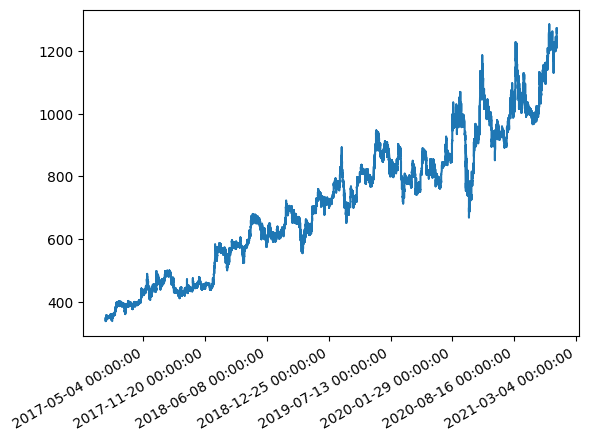

In [146]:
# x = [dt.datetime.strptime(d, '%Y-%m-%d').date() for d in df['Date'].values]
# x = [dt.datetime.strptime(d, '%m/%d/%Y').date() for d in df['Date'].values]
x = [dt.datetime.strptime(d[:-6], '%Y-%m-%d %H:%M:%S').date() for d in df['timestamp'].values]
y = [c for c in df['close'].values]

# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=200))
plt.plot(x, y)
plt.gcf().autofmt_xdate()

# Process data

In [147]:
import torch
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader

In [148]:
class StockDataset(Dataset):
    def __init__(self, X, y):
        assert len(X) == len(y)
        n = len(X)
        self.X = torch.tensor(X).view(n, 1, -1).float()
        self.y = torch.tensor(y).float()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [149]:
data = df['close'].to_numpy().reshape(-1, 1)

scaler = MinMaxScaler()

data = scaler.fit_transform(data)
data

array([[0.0026363 ],
       [0.0026363 ],
       [0.0026363 ],
       ...,
       [0.97289887],
       [0.97279342],
       [0.97279342]])

In [150]:
idx = [i for i, x in enumerate(np.isfinite(data)) if x]
data = data[idx]

In [151]:
X = []
y = []

for i in range(25, len(data), 10):
    X.append(data[i - 25: i - 5])
    y.append(data[i - 5: i])

X = np.array(X).reshape(-1, 20)
y = np.array(y).reshape(-1, 5)

X.shape, y.shape

((36975, 20), (36975, 5))

In [152]:
idx = [i for i in range(len(X))]
np.random.shuffle(idx)
X = X[idx]
y = y[idx]
train_len = int(len(X) * 0.8)
X_train, X_test = X[:train_len], X[train_len:]
y_train, y_test = y[:train_len], y[train_len:]

In [153]:
train_dataset = StockDataset(X_train, y_train)
test_dataset = StockDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=True)

# Experiment
## Nets

In [161]:
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CyclicLR
from nalu import NALU, INALU
from utils import train_model, train_inalu_model

In [170]:
class BaselineNet(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.model = nn.Sequential(nn.Conv1d(1, 1, 4),
                                   nn.Conv1d(1, 16, 4),
                                   nn.Conv1d(16, 32, 4),
                                   nn.MaxPool1d(2, 2),
                                   nn.Conv1d(32, 64, 4),
                                   nn.Flatten(1),
                                   nn.Linear(128, 64),
                                   nn.Dropout(),
                                   nn.Linear(64, 16),
                                   nn.Dropout(),
                                   nn.ReLU(),
                                   nn.Linear(16, 5),
                                   nn.Sigmoid()
                                   )

    def forward(self, x):
        return self.model(x)

In [171]:
class NALUNet(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.model = nn.Sequential(nn.Conv1d(1, 1, 4),
                                   nn.Conv1d(1, 16, 4),
                                   nn.Conv1d(16, 32, 4),
                                   nn.MaxPool1d(2, 2),
                                   nn.Conv1d(32, 64, 4),
                                   nn.Flatten(1),
                                   NALU(128, 64),
                                   nn.Dropout(),
                                   NALU(64, 16),
                                   nn.ReLU(),
                                   nn.Dropout(),
                                   nn.Linear(16, 5),
                                   nn.Sigmoid()
                                   )

    def forward(self, x):
        return self.model(x)

In [172]:
class INALUNet(nn.Module):
    def __init__(self, device='cuda', *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.device = device
        self.model = nn.Sequential(nn.Conv1d(1, 1, 4),
                                   nn.Conv1d(1, 16, 4),
                                   nn.Conv1d(16, 32, 4),
                                   nn.MaxPool1d(2, 2),
                                   nn.Conv1d(32, 64, 4),
                                   nn.Flatten(1))
        self.inalu1 = INALU(128, 64)
        self.dropout1 = nn.Dropout()
        self.inalu2 = INALU(64, 16)
        self.relu = nn.ReLU()
        self.dropout2 = nn.Dropout()
        self.linear = nn.Linear(16, 5)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.model(x).to(self.device)
        x = self.dropout1(self.inalu1(x)).to(self.device)
        x = self.dropout2(self.relu(self.inalu2(x))).to(self.device)
        return self.sigmoid(self.linear(x))

    def reinitialize(self):
        self.inalu1.reinitialize()
        self.inalu2.reinitialize()

    def reg_loss(self):
        return self.inalu1.reg_loss() \
            + self.inalu2.reg_loss()

In [173]:
def do_all(device, model, name):
    num_epochs = 100
    dataloaders = {'train': train_dataloader, 'test': test_dataloader}
    criterion = nn.MSELoss()
    optimizer = Adam(model.model.parameters(), lr=1e-4)
    scheduler = CyclicLR(optimizer, 1e-6, 1e-2, cycle_momentum=False)

    model, train_loss_his, test_loss_his = train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs, device, name)

    plt.plot(range(len(train_loss_his)), train_loss_his, label=f'{name}_train')
    plt.plot(range(len(test_loss_his)), test_loss_his, label=f'{name}_test')
    plt.xlabel('step')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

    running_loss = 0
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * inputs.size(0)

    full_loss = running_loss / len(dataloaders['test'].dataset)
    print(f'{name} loss: {full_loss}')

In [174]:
def check_work():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    nalu_model = NALUNet().to(device)
    do_all(device, nalu_model, 'nalu')

    baseline_model = BaselineNet().to(device)
    do_all(device, baseline_model, 'baseline')

    inalu_model = INALUNet().to(device)
    do_all(device, inalu_model, 'inalu')

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    inalu_model = INALUNet().to(device)
    num_epochs = 100
    dataloaders = {'train': train_dataloader, 'test': test_dataloader}
    criterion = nn.MSELoss()
    optimizer = Adam(inalu_model.parameters())
    scheduler = CyclicLR(optimizer, 1e-6, 1e-2, cycle_momentum=False)
    name = 'inalu'
    model, train_loss_his, test_loss_his = train_inalu_model(inalu_model, dataloaders, criterion, optimizer, scheduler, num_epochs, device, name)

    plt.plot(range(len(train_loss_his)), train_loss_his, label=f'{name}_train')
    plt.plot(range(len(test_loss_his)), test_loss_his, label=f'{name}_test')
    plt.xlabel('step')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

    running_loss = 0
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * inputs.size(0)

    full_loss = running_loss / len(dataloaders['test'].dataset)
    print(f'{name} loss: {full_loss}')

## AARTIIND with random shuffle

  0%|          | 0/100 [00:00<?, ?it/s]

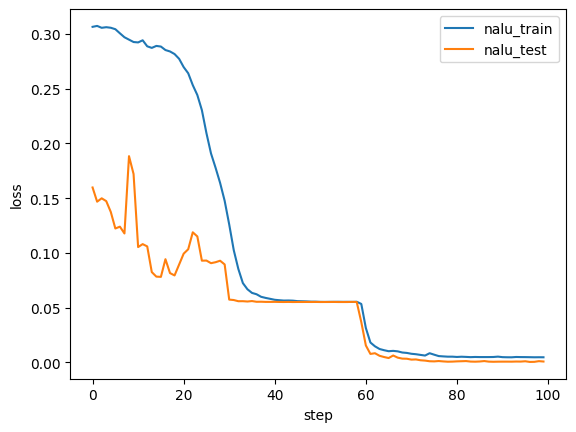

nalu loss: 0.0004609128616413667


  0%|          | 0/100 [00:00<?, ?it/s]

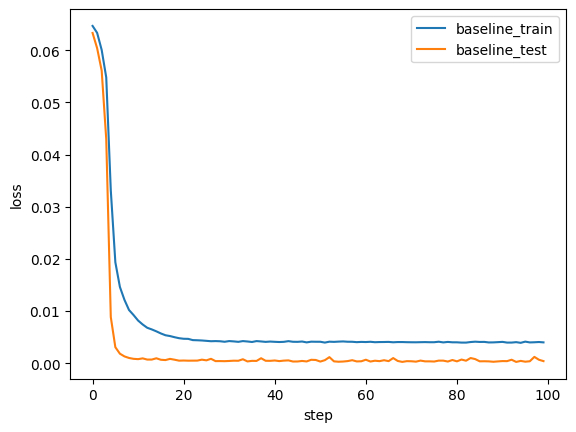

baseline loss: 0.00024642097764346875


  0%|          | 0/100 [00:00<?, ?it/s]

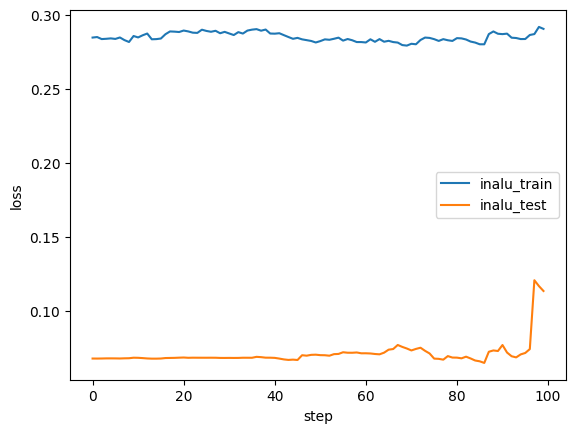

inalu loss: 0.06488654962095398


  0%|          | 0/100 [00:00<?, ?it/s]

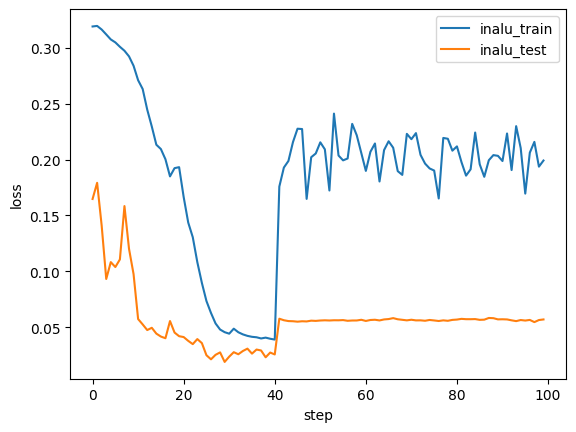

inalu loss: 0.019075018099992156


In [175]:
check_work()

In [ ]:
baseline loss: 0.00035517760636687954
nalu loss: 0.005227907452079958
inalu loss: 0.23271424518879238
inalu loss: 0.21080868122664717